# Imports

In [1]:
import sys
%load_ext autoreload
%autoreload 2

sys.path.append("../libs/")
from data_prep import *
from ML_functions import *
from bias_injection_and_fairness import *
from basic_visualizations import *

# Load prepared data and models

# Computations on train and test
Save all the fairness and accuracies values before and after optimiziation. This values will be used for plots and analysis

In [2]:
ls_vary=[np.round(i,3) for i in np.arange(0.2, 1.025, 0.025)]
ls_fixed=[0.25]

combinations_p1_p2 = (list(product(ls_vary, ls_fixed)) + list(product(ls_fixed, ls_vary)))

import joblib

#Initialize scores
test_acc_scores_initial=dict() ##keys should be tuples with values of p1,p2
test_acc_scores_optim_age=dict()
test_acc_scores_optim_gender=dict()
test_fairness_age_scores_optim_age=dict()
test_fairness_age_scores_optim_gender=dict()
test_fairness_gender_scores_optim_age=dict() #fairness gdner after optimiz for age
test_fairness_gender_scores_optim_gender=dict()
test_initial_fairness_age=dict()
test_initial_fairness_gender=dict()

train_acc_scores_initial=dict() ##keys should be tuples with values of p1,p2
train_acc_scores_optim_age=dict()
train_acc_scores_optim_gender=dict()
train_fairness_age_scores_optim_age=dict()
train_fairness_age_scores_optim_gender=dict()
train_fairness_gender_scores_optim_age=dict() #fairness gdner after optimiz for age
train_fairness_gender_scores_optim_gender=dict()
train_initial_fairness_age=dict()
train_initial_fairness_gender=dict()



##Do same for train!!!!!!!!!!!!!!!!!!


for p1, p2 in combinations_p1_p2:
    sufix_name= f'_{p1}_{p2}'
    X_train_with_A, X_val_with_A, X_test_with_A, y_train, y_val, y_test, age_train, age_val, \
            age_test, gender_train, gender_val, gender_test, ed_train, ed_val, ed_test= load_stored_data(
            age=True, gender=True, education=None,dataset_name='German_credit_biased', scale=True, sufix_name=f'_{p1}_{p2}')
    print('aaaaaaaaaaa',p1,p2)

    best_lr_A = joblib.load(f'../ML_models/German_credit_biased/best_logistic_regression_A_model{sufix_name}.pkl')



        ##Compute predictions


    y_train_pred_lr_A = best_lr_A.predict(X_train_with_A)
    y_val_pred_lr_A = best_lr_A.predict(X_val_with_A)
    y_test_pred_lr_A=best_lr_A.predict(X_test_with_A)
  

    threshold_optimizer = ThresholdOptimizer(estimator=best_lr_A, constraints="true_positive_rate_parity", objective= "accuracy_score", prefit=True)

    initial_acc_train_age, initial_acc_test_age, after_acc_train_age, after_acc_test_age, initial_fair_train_1_age, \
    initial_fair_test_1_age, after_fair_train_1_age, after_fair_test_1_age, initial_fair_train_2_age, initial_fair_test_2_age, after_fair_train_2_age, \
    after_fair_test_2_age = fairness_optimizer_results(threshold_optimizer,X_fit=X_val_with_A, y_fit=y_val_pred_lr_A, X_obs=X_test_with_A, y_obs=y_test_pred_lr_A, 
                y_train=y_val, y_val=y_test, sensitive_1_fit= age_val, sensitive_2_fit=gender_val, sensitive_1_obs= age_test, sensitive_2_obs=gender_test,
                name_1="AGE", name_2="GENDER", fitted=False) #optimize w.r.t age

    threshold_optimizer = ThresholdOptimizer(estimator=best_lr_A, constraints="true_positive_rate_parity", objective= "accuracy_score", prefit=True)

    initial_acc_train_gender, initial_acc_test_gender, after_acc_train_gender, after_acc_test_gender, initial_fair_train_1_gender, initial_fair_test_1_gender, \
            after_fair_train_1_gender, after_fair_test_1_gender, initial_fair_train_2_gender, initial_fair_test_2_gender, after_fair_train_2_gender,\
            after_fair_test_2_gender = fairness_optimizer_results(threshold_optimizer,X_fit=X_val_with_A, y_fit=y_val_pred_lr_A, X_obs=X_test_with_A, y_obs=y_test_pred_lr_A,
                    y_train=y_val, y_val=y_test, sensitive_1_fit= gender_val, sensitive_2_fit=age_val, sensitive_1_obs= gender_test, sensitive_2_obs=age_test,
                    name_1="GENDER", name_2="AGE", fitted=False) #optimize w.r.t gender

    print(initial_acc_train_age, initial_acc_test_age, after_acc_train_age, after_acc_test_age, initial_fair_train_1_age, initial_fair_test_1_age, after_fair_train_1_age, after_fair_test_1_age, initial_fair_train_2_age, initial_fair_test_2_age, after_fair_train_2_age, after_fair_test_2_age )
    test_acc_scores_initial[(p1,p2)] = initial_acc_test_age #age does not matter! REMOVE LATER!!!
    test_acc_scores_optim_age[(p1,p2)] = after_acc_test_age #optimiz after age
    test_acc_scores_optim_gender[(p1,p2)] = after_acc_test_gender #optimize after gender
    test_fairness_age_scores_optim_age[(p1,p2)] = after_fair_test_1_age #optimiz after age
    test_fairness_age_scores_optim_gender[(p1,p2)] =after_fair_test_2_gender
    test_fairness_gender_scores_optim_age[(p1,p2)] = after_fair_test_2_age #fairness gender after optimiz for age
    test_fairness_gender_scores_optim_gender[(p1,p2)] = after_fair_test_1_gender
    test_initial_fairness_age[(p1,p2)] =initial_fair_test_1_age
    test_initial_fairness_gender[(p1,p2)] =initial_fair_test_1_gender
    assert initial_fair_test_1_age == initial_fair_test_2_gender , 'Initial fairness for age should be equal.'

    ###DO THE SAME FOR TRAIN
    train_acc_scores_initial[(p1,p2)] = initial_acc_train_age ##age does not matter! REMOVE LATER!!!
    train_acc_scores_optim_age[(p1,p2)] = after_acc_train_age #optimiz after age
    train_acc_scores_optim_gender[(p1,p2)] = after_acc_train_gender
    train_fairness_age_scores_optim_age[(p1,p2)] = after_fair_train_1_age ##optimiz after age
    train_fairness_age_scores_optim_gender[(p1,p2)] =after_fair_train_2_gender
    train_fairness_gender_scores_optim_age[(p1,p2)] = after_fair_train_2_age #fairness gender after optimiz for age
    train_fairness_gender_scores_optim_gender[(p1,p2)] = after_fair_train_1_gender
    train_initial_fairness_age[(p1,p2)] =initial_fair_train_1_age
    train_initial_fairness_gender[(p1,p2)] =initial_fair_train_1_gender
    assert initial_fair_train_1_age == initial_fair_train_2_gender , 'Initial fairness for age should be equal.'

        

        


aaaaaaaaaaa 0.2 0.25
0.7777777777777778 0.8031496062992126 0.746031746031746 0.7244094488188977 0.489406779661017 0.24 0.021186440677966156 0.08000000000000007 0.3153846153846154 0.8653846153846154 0.7538461538461538 0.7692307692307693
aaaaaaaaaaa 0.225 0.25
0.8031496062992126 0.75 0.7322834645669292 0.7265625 0.6816239316239316 0.5773809523809523 0.014957264957265015 0.04166666666666663 0.5921052631578947 0.4974358974358975 0.16228070175438591 0.5743589743589743
aaaaaaaaaaa 0.25 0.25
0.7131782945736435 0.7538461538461538 0.7209302325581395 0.6461538461538462 0.49561403508771923 0.5714285714285714 0.02631578947368418 0.061224489795918324 0.675 0.7796610169491526 0.275 0.5466101694915254
aaaaaaaaaaa 0.275 0.25
0.7615384615384615 0.7 0.7384615384615385 0.6615384615384615 0.519893899204244 0.5725 0.02652519893899208 0.13749999999999996 0.43589743589743596 0.30158730158730157 0.07435897435897432 0.17460317460317465
aaaaaaaaaaa 0.3 0.25
0.7786259541984732 0.7954545454545454 0.73282442748091

# DO a quick sanity check that bias injection works
We will plot the eq op difference of the model for different probabilities of keeping positive samples w.r.t the sensitive feature
We expect a decreasing trend in the plots

-----  INJECT BIAS FOR AGE -----


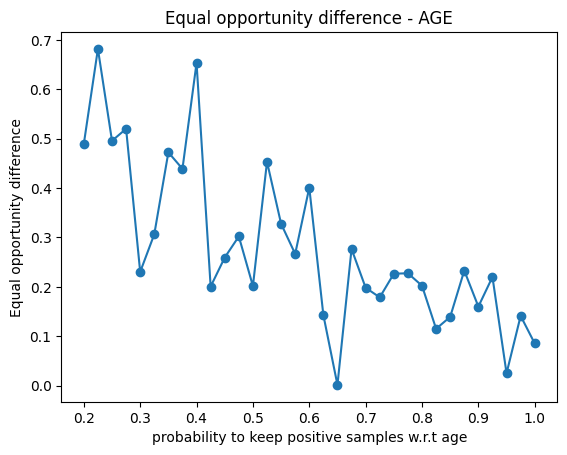

Spearman r correaltion test for age bias injection:  SignificanceResult(statistic=-0.7740641711229946, pvalue=1.2628541745979532e-07)

--------- INJECT BIAS FOR GENDER----------



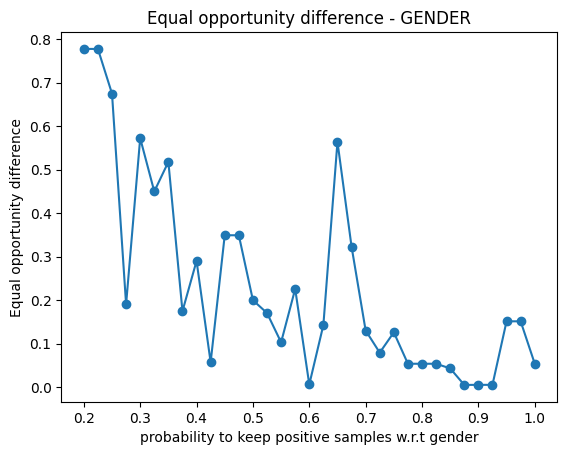

Spearman r correaltion test for gender bias injection:  SignificanceResult(statistic=-0.7625419766092241, pvalue=2.5016103820881206e-07)


In [10]:

###Fairness reudction w.r.t. AGE (i.e. drop positive age samples)

print('-----  INJECT BIAS FOR AGE -----')

p2=ls_fixed[0] #Fix no drop in positive samples w.r.t gender
vals_before=[]
for p1 in ls_vary:
    vals_before.append(train_initial_fairness_age[(p1,p2)]) ## Fairness age 

plot_values(ls_vary, vals_before,"Equal opportunity difference - AGE",x_axis_name="probability to keep positive samples w.r.t age", y_axis_name="Equal opportunity difference")
print('Spearman r correlation test for age bias injection: ',spearmanr(ls_vary, vals_before))





print()
print("--------- INJECT BIAS FOR GENDER----------")
print()



p1=ls_fixed[0] #Fix no drop in positive samples w.r.t age  (keep it fixed)
vals_before=[]
for p2 in ls_vary:
    vals_before.append(train_initial_fairness_gender[(p1,p2)]) ## Fairness age 

plot_values(ls_vary, vals_before,"Equal opportunity difference - GENDER",x_axis_name="probability to keep positive samples w.r.t gender", y_axis_name="Equal opportunity difference")
print('Spearman r correlation test for gender bias injection: ',spearmanr(ls_vary, vals_before))







# Compare results for fairness and accuracy before and after optimization

Plots for train

---------- OPTIMIZE W.R.T AGE----------


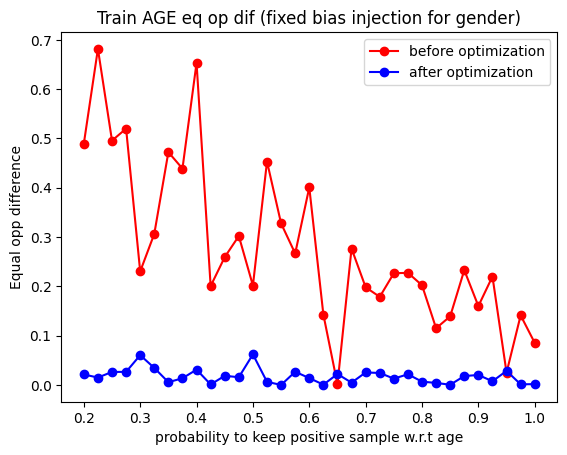

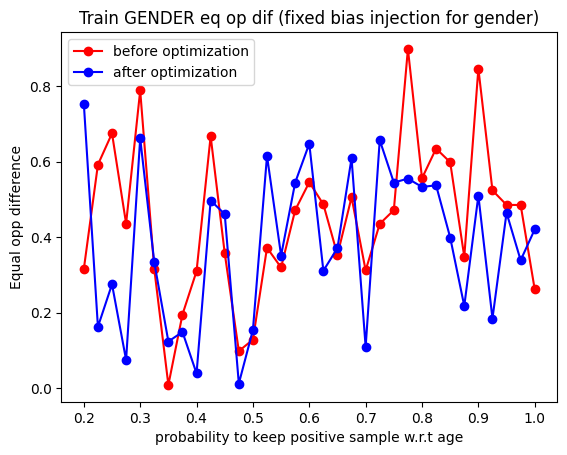

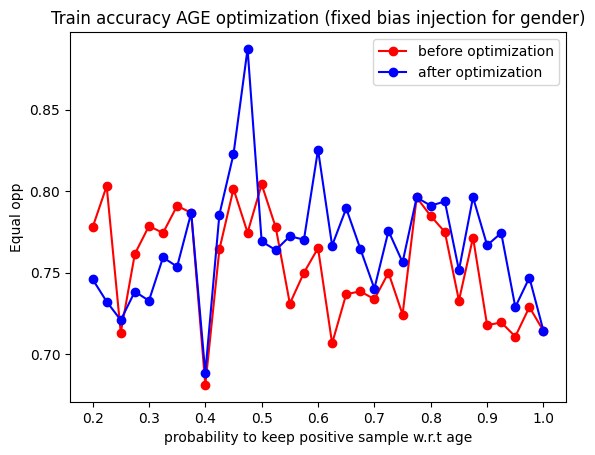

---------- OPTIMIZE W.R.T GENDER----------


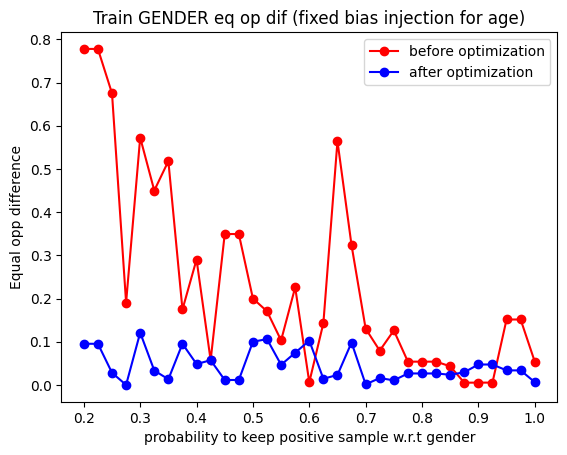

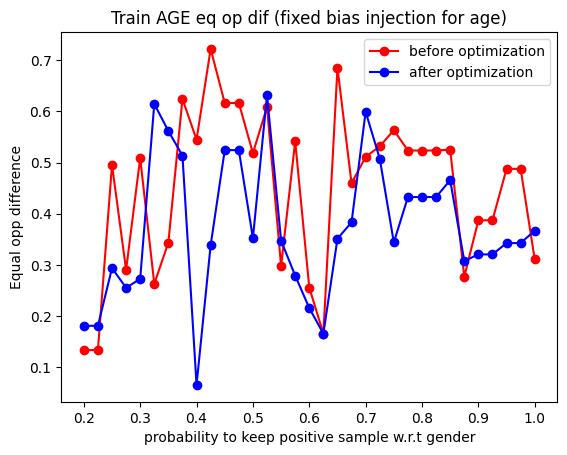

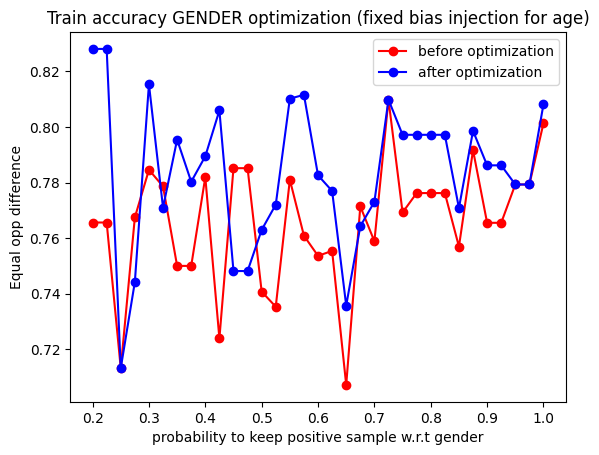

In [8]:

### OPTIMIZATION w.r.t age

###Fairness reudction AGE

#p1 for age; p2 for gender

vals_before=[]
vals_after=[]


print("---------- OPTIMIZE W.R.T AGE----------")

p2=ls_fixed[0]
for p1 in ls_vary:
    vals_before.append(train_initial_fairness_age[(p1,p2)])
    vals_after.append(train_fairness_age_scores_optim_age[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2= vals_after, plot_name=f"Train AGE eq op dif (fixed bias injection for gender)", 
                        x_axis_name="probability to keep positive sample w.r.t age", y_axis_name="Equal opp difference")

vals_before=[]
vals_after=[]
### Gender Fairness affected
p2=ls_fixed[0]
for p1 in ls_vary:
    vals_before.append(train_initial_fairness_gender[(p1,p2)])
    vals_after.append(train_fairness_gender_scores_optim_age[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2= vals_after, plot_name=f"Train GENDER eq op dif (fixed bias injection for gender)",
                        x_axis_name="probability to keep positive sample w.r.t age", y_axis_name="Equal opp difference")



###ACCURACY reduction
    

vals_before=[]
vals_after=[]
### Gender Fairness affected
p2=ls_fixed[0]    
for p1 in ls_vary:
    vals_before.append(train_acc_scores_initial[(p1,p2)])
    vals_after.append(train_acc_scores_optim_age[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2=vals_after, plot_name=f"Train accuracy AGE optimization (fixed bias injection for gender)"
                        ,x_axis_name="probability to keep positive sample w.r.t age", y_axis_name="Equal opp")


    


print("---------- OPTIMIZE W.R.T GENDER----------")

## Optimization w.r.t gender
vals_before=[]
vals_after=[]

p1=ls_fixed[0]
for p2 in ls_vary:
    vals_before.append(train_initial_fairness_gender[(p1,p2)])
    vals_after.append(train_fairness_gender_scores_optim_gender[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2= vals_after, plot_name=f"Train GENDER eq op dif (fixed bias injection for age)", 
                        x_axis_name="probability to keep positive sample w.r.t gender", y_axis_name="Equal opp difference")

vals_before=[]
vals_after=[]
### AGE Fairness affected
p1=ls_fixed[0]
for p2 in ls_vary:
    vals_before.append(train_initial_fairness_age[(p1,p2)])
    vals_after.append(train_fairness_age_scores_optim_gender[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2= vals_after, plot_name=f"Train AGE eq op dif (fixed bias injection for age)",
                        x_axis_name="probability to keep positive sample w.r.t gender", y_axis_name="Equal opp difference")



###ACCURACY reduction
    

vals_before=[]
vals_after=[]
### Gender Fairness affected
p1=ls_fixed[0]    
for p2 in ls_vary:
    vals_before.append(train_acc_scores_initial[(p1,p2)])
    vals_after.append(train_acc_scores_optim_gender[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2=vals_after, plot_name=f"Train accuracy GENDER optimization (fixed bias injection for age)"
                        ,x_axis_name="probability to keep positive sample w.r.t gender", y_axis_name="Equal opp difference")


 



Plots for test

---------- OPTIMIZE W.R.T AGE----------


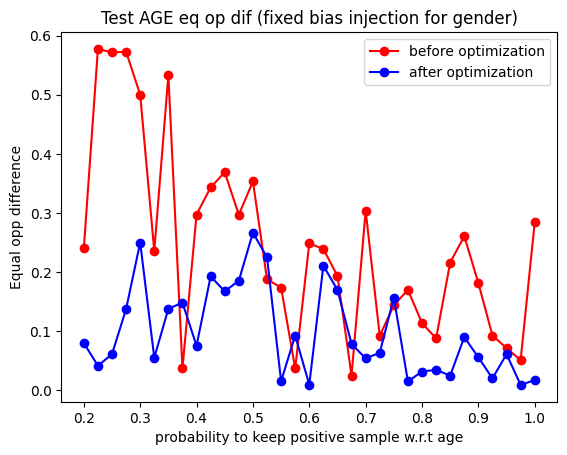

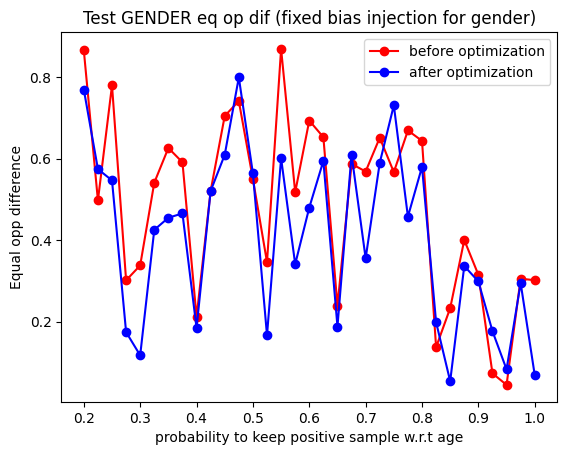

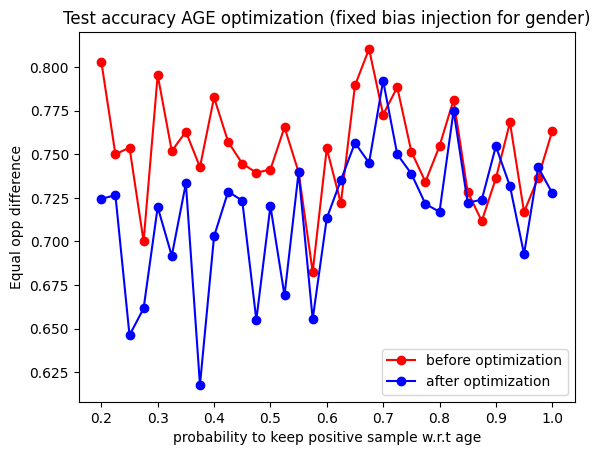



---------- OPTIMIZE W.R.T GENDEER----------


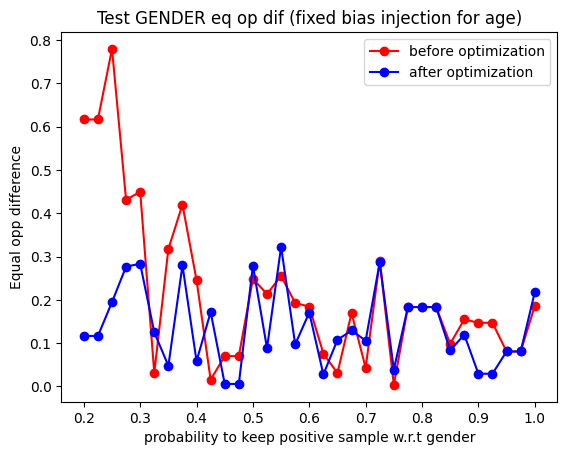

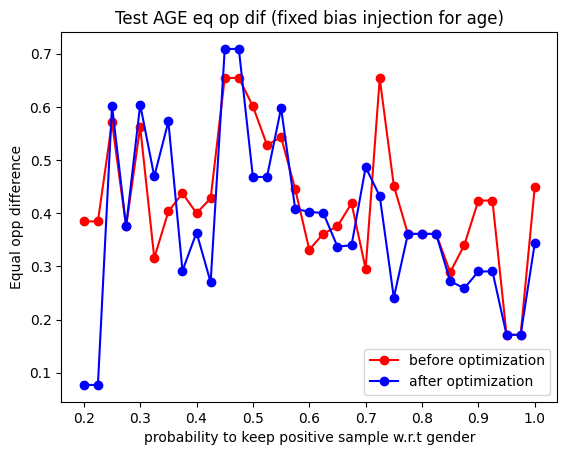

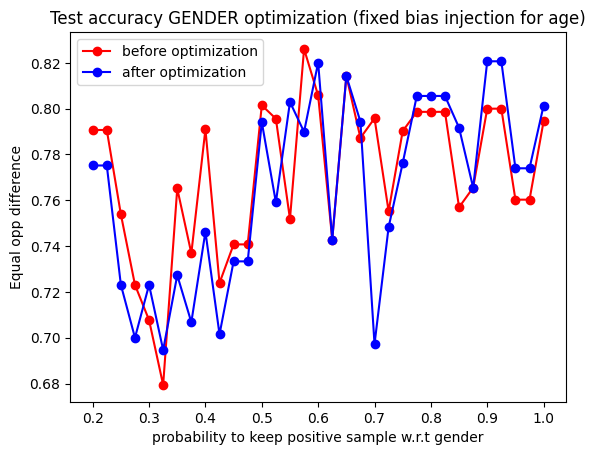

In [9]:

### OPTIMIZATION w.r.t age

###Fairness reudction AGE

#p1 for age; p2 for gender

vals_before=[]
vals_after=[]

print("---------- OPTIMIZE W.R.T AGE----------")

p2=ls_fixed[0]
for p1 in ls_vary:
    vals_before.append(test_initial_fairness_age[(p1,p2)])
    vals_after.append(test_fairness_age_scores_optim_age[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2= vals_after, plot_name=f"Test AGE eq op dif (fixed bias injection for gender)", 
                        x_axis_name="probability to keep positive sample w.r.t age", y_axis_name="Equal opp difference")

vals_before=[]
vals_after=[]
### Gender Fairness affected
p2=ls_fixed[0]
for p1 in ls_vary:
    vals_before.append(test_initial_fairness_gender[(p1,p2)])
    vals_after.append(test_fairness_gender_scores_optim_age[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2= vals_after, plot_name=f"Test GENDER eq op dif (fixed bias injection for gender)",
                        x_axis_name="probability to keep positive sample w.r.t age", y_axis_name="Equal opp difference")



###ACCURACY reduction
    

vals_before=[]
vals_after=[]
### Gender Fairness affected
p2=ls_fixed[0]    
for p1 in ls_vary:
    vals_before.append(test_acc_scores_initial[(p1,p2)])
    vals_after.append(test_acc_scores_optim_age[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2=vals_after, plot_name=f"Test accuracy AGE optimization (fixed bias injection for gender)"
                        ,x_axis_name="probability to keep positive sample w.r.t age", y_axis_name="Equal opp difference")









## Optimize w.r.t gender
vals_before=[]
vals_after=[]
print()
print()
print("---------- OPTIMIZE W.R.T GENDEER----------")

p1=ls_fixed[0]
for p2 in ls_vary:
    vals_before.append(test_initial_fairness_gender[(p1,p2)])
    vals_after.append(test_fairness_gender_scores_optim_gender[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2= vals_after, plot_name=f"Test GENDER eq op dif (fixed bias injection for age)", 
                        x_axis_name="probability to keep positive sample w.r.t gender", y_axis_name="Equal opp difference")

vals_before=[]
vals_after=[]
### AGE Fairness affected
p1=ls_fixed[0]
for p2 in ls_vary:
    vals_before.append(test_initial_fairness_age[(p1,p2)])
    vals_after.append(test_fairness_age_scores_optim_gender[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2= vals_after, plot_name=f"Test AGE eq op dif (fixed bias injection for age)",
                        x_axis_name="probability to keep positive sample w.r.t gender", y_axis_name="Equal opp difference")



###ACCURACY reduction
    

vals_before=[]
vals_after=[]
### Gender Fairness affected
p1=ls_fixed[0]    
for p2 in ls_vary:
    vals_before.append(test_acc_scores_initial[(p1,p2)])
    vals_after.append(test_acc_scores_optim_gender[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2=vals_after, plot_name=f"Test accuracy GENDER optimization (fixed bias injection for age)"
                        ,x_axis_name="probability to keep positive sample w.r.t gender", y_axis_name="Equal opp difference")


    



# How optimization affects the fairness/accuracy
# Correlation Increase in fairness, change (increase/decrease) in accuracy
(i.e. use statistical test that compares the fairness effect with the accuracy effect. i.e. correlation between fairness_after- fairnes_before and acc_after-acc_before and between 2 types of fairness
also do plots with x axis the percentage of positive sample kept and y axis the fairness/acc difference between after and before )


Train data

----------- TRAIN DATA ----------


----- Trends in comparing BEFORE and AFTER optimization w.r.t age when injecting bias in age (i.e vary age) ----- 

Vary age and optimize w.r.t age



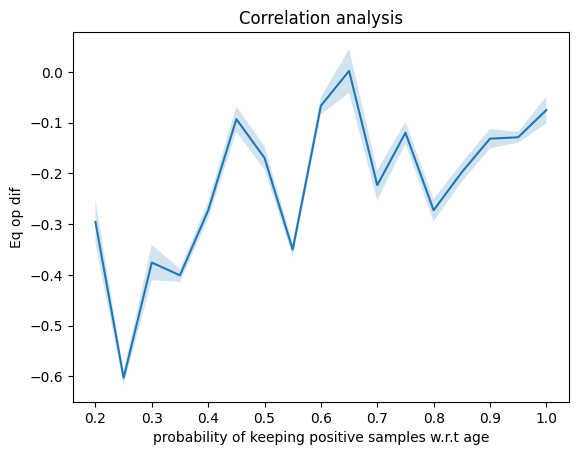

 Correlation between probability of keeping positive samples w.r.t age and age fairness increase: SignificanceResult(statistic=0.6127450980392157, pvalue=0.008919495078273144)


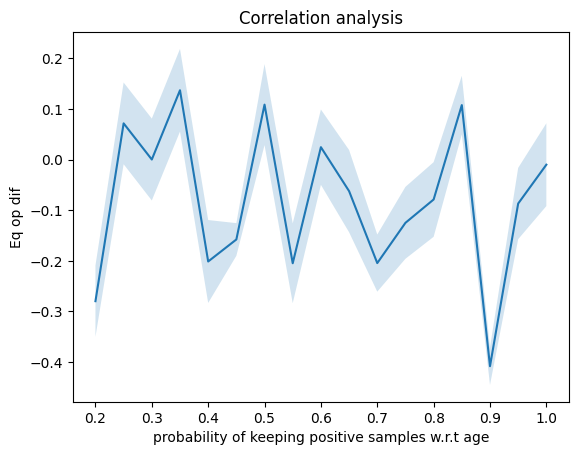

  Correlation between probability of keeping positive samples w.r.t age and gender fairness increase: SignificanceResult(statistic=-0.10784313725490197, pvalue=0.6803504180481623)


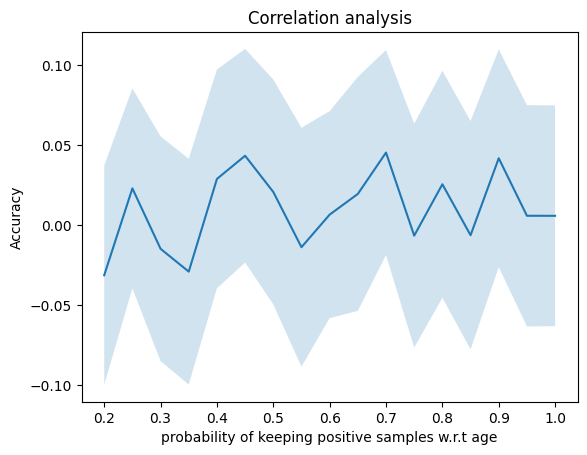

 Correlation between probability of keeping positive samples w.r.t age and accuracy increase: SignificanceResult(statistic=0.22794117647058826, pvalue=0.37891058826948376)

-- RESULTS ABOUT CORRELATION BETWEEN FAIRNESS AND ACC --
Coorelation between age fairness improvement and gender fairness : SignificanceResult(statistic=-0.06372549019607844, pvalue=0.808021077411703)
Coorelation between age fairness improvement and accuracy : SignificanceResult(statistic=0.27696078431372556, pvalue=0.281843162514077)


----- Trends in comparing BEOFRE and AFTER optimization  w.r.t gender when injecting bias in gender (i.e. vary gender) ----- 

Vary gender and optimize w.r.t gender



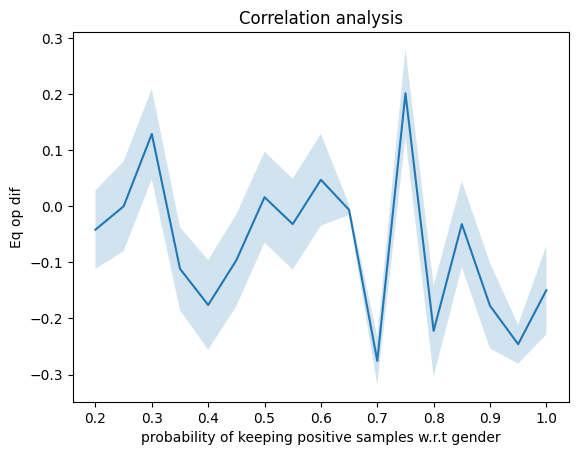

 Correlation between probability of keeping positive samples w.r.t gender and age fairness increase: SignificanceResult(statistic=-0.3872549019607844, pvalue=0.12460639350840541)


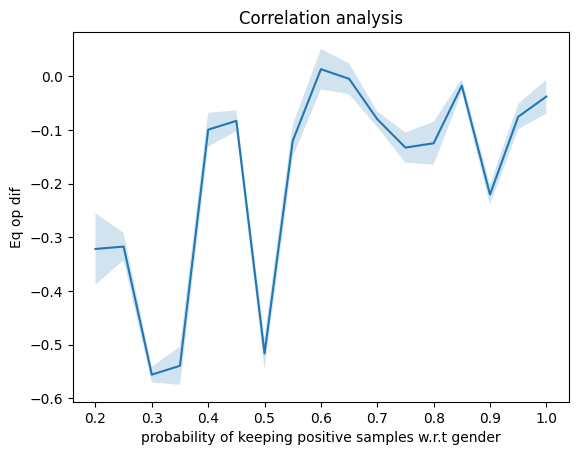

 Correlation between probability of keeping positive samples w.r.t gender and gender fairness increase: SignificanceResult(statistic=0.5784313725490197, pvalue=0.014996936854650101)


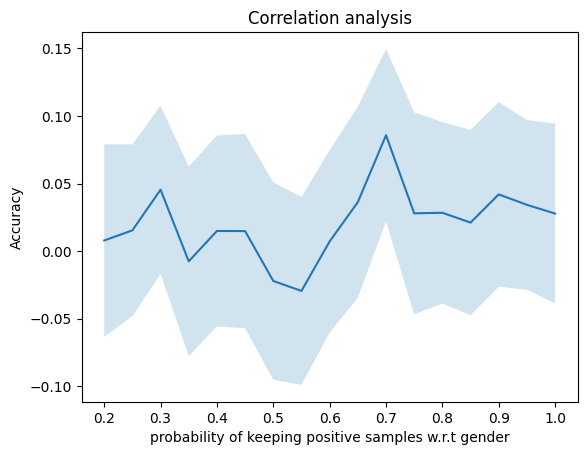

Correlation between probability of keeping positive samples w.r.t gender and accuracy increase:: SignificanceResult(statistic=0.4338235294117647, pvalue=0.08189345203365929)

-- RESULTS ABOUT CORRELATION BETWEEN FAIRNESS AND ACC --
Coorelation between gender fairness improvement and age fairness : SignificanceResult(statistic=-0.18382352941176472, pvalue=0.4800344013399136)
Coorelation between gender fairness improvement and accuracy : SignificanceResult(statistic=0.14460784313725492, pvalue=0.5797547992794121)




In [17]:


print("----------- TRAIN DATA ----------")

print()
print()


print("----- Trends in comparing BEFORE and AFTER optimization w.r.t age when injecting bias in age (i.e vary age) ----- ")
print()
find_trend_optimization(before_fairness_age = train_initial_fairness_age , before_fairness_gender= train_initial_fairness_gender, before_accuracy = train_acc_scores_initial,
                        after_fairness_age = train_fairness_age_scores_optim_age, after_fairness_gender = train_fairness_gender_scores_optim_age, after_accuracy = train_acc_scores_optim_age,
                        correlation_test = spearmanr, ls_p_vary = ls_vary, vary_age=True, size1=X_val_with_A.shape[0], size2=X_val_with_A.shape[0])
    
            
         
print("----- Trends in comparing BEOFRE and AFTER optimization  w.r.t gender when injecting bias in gender (i.e. vary gender) ----- ")
print()
find_trend_optimization(before_fairness_age = train_initial_fairness_age , before_fairness_gender= train_initial_fairness_gender, before_accuracy = train_acc_scores_initial,
                        after_fairness_age = train_fairness_age_scores_optim_gender, after_fairness_gender = train_fairness_gender_scores_optim_gender, after_accuracy = train_acc_scores_optim_gender,
                        correlation_test = spearmanr, ls_p_vary = ls_vary, vary_age=False, size1=X_val_with_A.shape[0], size2=X_val_with_A.shape[0])


## Maybe also compare optimiz age when vary gender just to check that there is no clear correlation

Test data

----------- TEST DATA ----------


----- Trends in comparing BEFORE and AFTER optimization w.r.t age when injecting bias in age (i.e vary age) ----- 

Vary age and optimize w.r.t age



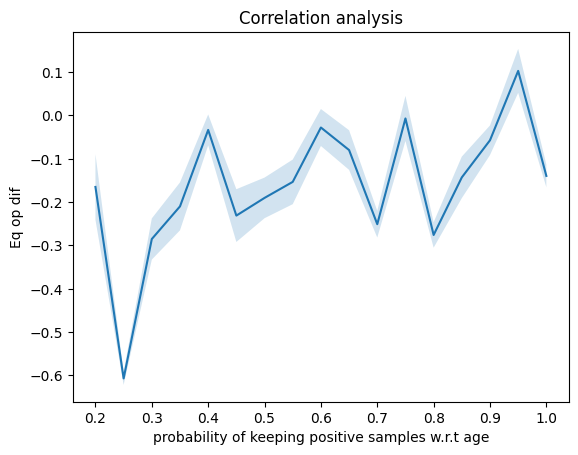

 Correlation between probability of keeping positive samples w.r.t age and age fairness increase: SignificanceResult(statistic=0.5098039215686275, pvalue=0.036568145531216414)


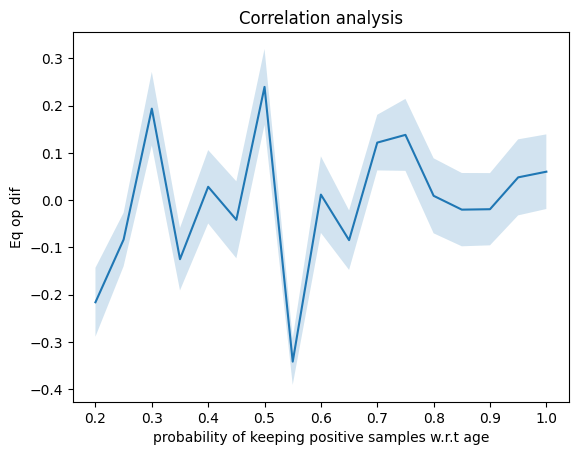

  Correlation between probability of keeping positive samples w.r.t age and gender fairness increase: SignificanceResult(statistic=0.30637254901960786, pvalue=0.23168960494057989)


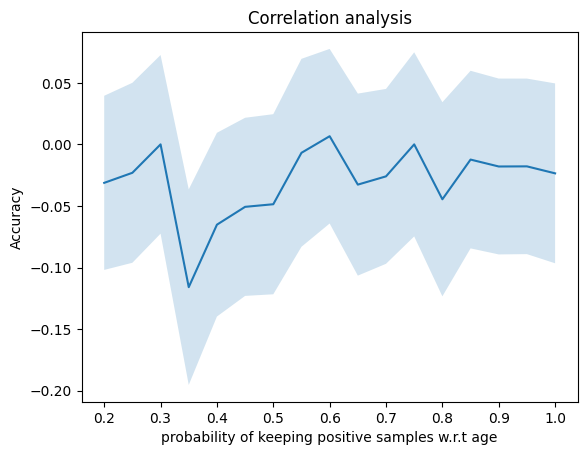

 Correlation between probability of keeping positive samples w.r.t age and accuracy increase: SignificanceResult(statistic=0.27590440501616836, pvalue=0.2837581783201547)

-- RESULTS ABOUT CORRELATION BETWEEN FAIRNESS AND ACC --
Coorelation between age fairness improvement and gender fairness : SignificanceResult(statistic=0.11764705882352941, pvalue=0.6529334399539918)
Coorelation between age fairness improvement and accuracy : SignificanceResult(statistic=0.29675051561739, pvalue=0.24742492598792093)


----- Trends in comparing BEOFRE and AFTER optimization  w.r.t gender when injecting bias in gender (i.e. vary gender) ----- 

Vary gender and optimize w.r.t gender



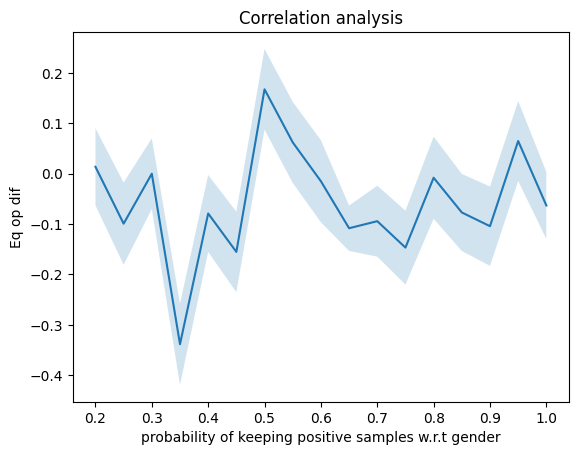

 Correlation between probability of keeping positive samples w.r.t gender and age fairness increase: SignificanceResult(statistic=0.04411764705882353, pvalue=0.8664832749198724)


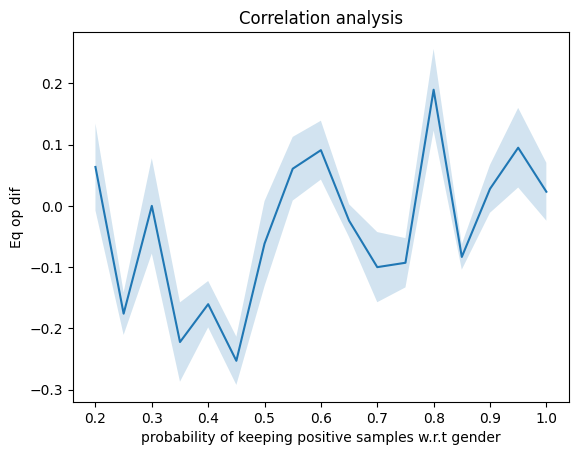

 Correlation between probability of keeping positive samples w.r.t gender and gender fairness increase: SignificanceResult(statistic=0.39460784313725494, pvalue=0.11700232160229736)


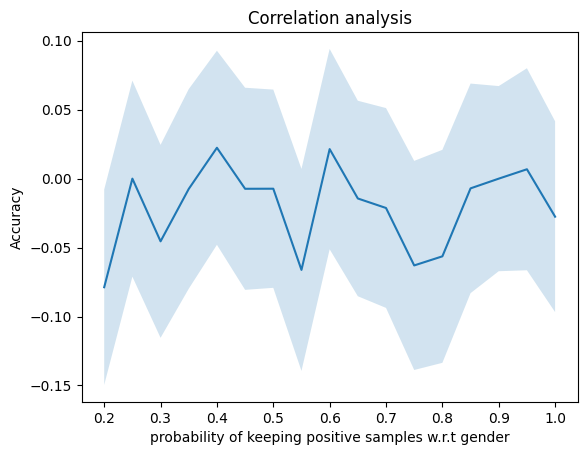

Correlation between probability of keeping positive samples w.r.t gender and accuracy increase:: SignificanceResult(statistic=0.10177806940596434, pvalue=0.6975057342204392)

-- RESULTS ABOUT CORRELATION BETWEEN FAIRNESS AND ACC --
Coorelation between gender fairness improvement and age fairness : SignificanceResult(statistic=0.6887254901960785, pvalue=0.0022327017176758217)
Coorelation between gender fairness improvement and accuracy : SignificanceResult(statistic=-0.19006747901113824, pvalue=0.4649758121935368)




In [18]:
from scipy.stats import spearmanr

print("----------- TEST DATA ----------")

print()
print()


print("----- Trends in comparing BEFORE and AFTER optimization w.r.t age when injecting bias in age (i.e vary age) ----- ")
print()
find_trend_optimization(before_fairness_age = test_initial_fairness_age , before_fairness_gender= test_initial_fairness_gender, before_accuracy = test_acc_scores_initial,
                        after_fairness_age = test_fairness_age_scores_optim_age, after_fairness_gender = test_fairness_gender_scores_optim_age, after_accuracy = test_acc_scores_optim_age,
                        correlation_test = spearmanr, ls_p_vary = ls_vary, vary_age=True, size1=X_test_with_A.shape[0], size2=X_test_with_A.shape[0])
    
            
         
print("----- Trends in comparing BEOFRE and AFTER optimization  w.r.t gender when injecting bias in gender (i.e. vary gender) ----- ")
print()
find_trend_optimization(before_fairness_age = test_initial_fairness_age , before_fairness_gender= test_initial_fairness_gender, before_accuracy = test_acc_scores_initial,
                        after_fairness_age = test_fairness_age_scores_optim_gender, after_fairness_gender = test_fairness_gender_scores_optim_gender, after_accuracy = test_acc_scores_optim_gender,
                        correlation_test = spearmanr, ls_p_vary = ls_vary, vary_age=False, size1=X_test_with_A.shape[0], size2=X_test_with_A.shape[0])


## Maybe also compare optimiz age when vary gender just to check that there is no clear correlation

# BACKUP

In [ ]:


print("----------- TRAIN DATA ----------")

print()
print()

print("----- Trend for initial data when injecting bias in age (i.e vary age) ----- ")
print()
find_trend (data_fairness_age=train_initial_fairness_age, data_fairness_gender = train_initial_fairness_gender, data_accuracy = train_acc_scores_initial, 
            correlation_test=spearmanr, ls_p_vary= ls_vary, vary_age = True )
            
print("----- Trend for initial data when injecting bias in gender (i.e. vary gender) ----- ")
print()
find_trend (data_fairness_age=train_initial_fairness_age, data_fairness_gender = train_initial_fairness_gender, data_accuracy = train_acc_scores_initial, 
            correlation_test=spearmanr, ls_p_vary= ls_vary, vary_age = False )


print("----- Trend after optimization w.r.t age when injecting bias in age (i.e vary age) ----- ")
print()
find_trend (data_fairness_age=train_fairness_age_scores_optim_age, data_fairness_gender = train_fairness_gender_scores_optim_age, data_accuracy = train_acc_scores_optim_age, 
            correlation_test=spearmanr, ls_p_vary= ls_vary, vary_age = True )
            
print("----- Trend after optimization w.r.t age when injecting bias in gender (i.e. vary gender) ----- ")
print()
find_trend (data_fairness_age=train_fairness_age_scores_optim_age, data_fairness_gender = train_fairness_gender_scores_optim_age, data_accuracy = train_acc_scores_optim_age, 
            correlation_test=spearmanr, ls_p_vary= ls_vary, vary_age = False )

print("----- Trend after optimization w.r.t gender when injecting bias in age (i.e vary age) ----- ")
print()
find_trend (data_fairness_age=train_fairness_age_scores_optim_gender, data_fairness_gender = train_fairness_gender_scores_optim_gender, data_accuracy = train_acc_scores_optim_gender, 
            correlation_test=spearmanr, ls_p_vary= ls_vary, vary_age = True )
            
print("----- Trend after optimization w.r.t gender when injecting bias in gender (i.e. vary gender) ----- ")
print()
find_trend (data_fairness_age=train_fairness_age_scores_optim_gender, data_fairness_gender = train_fairness_gender_scores_optim_gender, data_accuracy = train_acc_scores_optim_gender, 
            correlation_test=spearmanr, ls_p_vary= ls_vary, vary_age = False )

In [ ]:


print("----------- TEST DATA ----------")

print()
print()

print("----- Trend for initial data when injecting bias in age (i.e vary age) ----- ")
print()
find_trend (data_fairness_age=test_initial_fairness_age, data_fairness_gender = test_initial_fairness_gender, data_accuracy = test_acc_scores_initial, 
            correlation_test=spearmanr, ls_p_vary= ls_vary, vary_age = True )
            
print("----- Trend for initial data when injecting bias in gender (i.e. vary gender) ----- ")
print()
find_trend (data_fairness_age=test_initial_fairness_age, data_fairness_gender = test_initial_fairness_gender, data_accuracy = test_acc_scores_initial, 
            correlation_test=spearmanr, ls_p_vary= ls_vary, vary_age = False )


print("----- Trend after optimization w.r.t age when injecting bias in age (i.e vary age) ----- ")
print()
find_trend (data_fairness_age=test_fairness_age_scores_optim_age, data_fairness_gender = test_fairness_gender_scores_optim_age, data_accuracy = test_acc_scores_optim_age, 
            correlation_test=spearmanr, ls_p_vary= ls_vary, vary_age = True )
            
print("----- Trend after optimization w.r.t age when injecting bias in gender (i.e. vary gender) ----- ")
print()
find_trend (data_fairness_age=test_fairness_age_scores_optim_age, data_fairness_gender = test_fairness_gender_scores_optim_age, data_accuracy = test_acc_scores_optim_age, 
            correlation_test=spearmanr, ls_p_vary= ls_vary, vary_age = False )

print("----- Trend after optimization w.r.t gender when injecting bias in age (i.e vary age) ----- ")
print()
find_trend (data_fairness_age=test_fairness_age_scores_optim_gender, data_fairness_gender = test_fairness_gender_scores_optim_gender, data_accuracy = test_acc_scores_optim_gender, 
            correlation_test=spearmanr, ls_p_vary= ls_vary, vary_age = True )
            
print("----- Trend after optimization w.r.t gender when injecting bias in gender (i.e. vary gender) ----- ")
print()
find_trend (data_fairness_age=test_fairness_age_scores_optim_gender, data_fairness_gender = test_fairness_gender_scores_optim_gender, data_accuracy = test_acc_scores_optim_gender, 
            correlation_test=spearmanr, ls_p_vary= ls_vary, vary_age = False )

# Correlation Increase in fairness, change (increase/decrease) in accuracy
(i.e. use statistical test that compares the fairness effect with the accuracy effect. i.e. correlation between fairness_after- fairnes_before and acc_after-acc_before )


Train set

Test set

# Shap analysis

In [ ]:
import joblib
import shap
model=best_lr_A = joblib.load(f'../ML_models/German_credit_biased/best_logistic_regression_A_model_0.2_1.pkl')
explainer = shap.TreeExplainer(model)
X_train_with_A = pd.read_csv(os.path.join('../Dataframes/German_credit_biased', f'X_train_with_A_0.2_1.csv'))
X_test_with_A = pd.read_csv(os.path.join('../Dataframes/German_credit_biased', f'X_test_with_A_0.2_1.csv'))
shap_values = explainer.shap_values(X)
model
# Create a Shap dependency plot for Feature1
shap.dependence_plot('Feature1', shap_values, X)

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._logistic.LogisticRegression'>